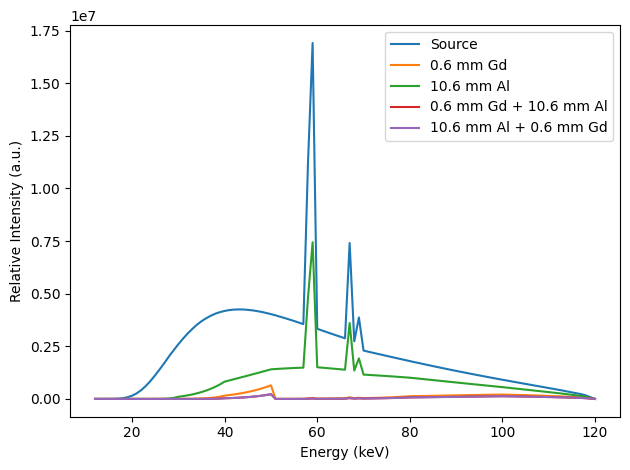

In [16]:
import math, numpy as np

# ---------- 1) 读文件工具（自动跳过非数字行） ----------
def load_two_cols(path):
    E, Y = [], []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            s = ln.strip().split()
            if len(s) < 2: 
                continue
            try:
                e = float(s[0]); y = float(s[1])
            except ValueError:
                continue
            E.append(e); Y.append(y)
    E = np.asarray(E, float); Y = np.asarray(Y, float)
    idx = np.argsort(E)
    return E[idx], Y[idx]

# 2) 输入路径  
spek_path = "spek_120.txt"      # X 射线的原始能谱， 由 SpekCalc 导出
 
xcom_gd_path = "Gd_mu_over_rho.csv"     # XCOM 查表得到 Gd 的 (mu/rho) CSV  (两列：Energy[keV], mu_over_rho[cm^2/g])
xcom_al_path = "Al_mu_over_rho.csv"     


# 3) 读取数据 
E_keV, Phi_in = load_two_cols(spek_path)
gd_Ex_MeV, gd_mu_over_rho = load_two_cols(xcom_gd_path)  # Gd
al_Ex_MeV, al_mu_over_rho = load_two_cols(xcom_al_path)  # Gd

# if Ex_MeV.max() < 10 and E_keV.max() > 10:
gd_Ex_keV = gd_Ex_MeV * 1000.0   # MeV -> keV
al_Ex_keV = al_Ex_MeV * 1000.0   # MeV -> keV


# 4) 参数：Gd 密度与厚度 
rho_gd = 7.90       # g/cm^3（Gd 密度）         釓（Gd）的密度为 (7.895 g/cm}^{3})
rho_al = 2.70       # 铝（Al）的密度是约 (2.70 g/cm}^{3})
rho_pb = 11.3437    # 铅的密度是 11.3437 g/cm^3.


thickness_mm_gd = 0.6  # 滤波片厚度（mm）
x_cm_gd = thickness_mm_gd * 0.1  # mm -> cm

thickness_mm_al = 10.6  # 滤波片厚度（mm）
x_cm_al = thickness_mm_al * 0.1  # mm -> cm



# 5) 计算  N = N0 * exp(-(mu/rho)*rho*x)  
mu_rho_interp_gd = np.interp(E_keV, gd_Ex_keV, 
                          gd_mu_over_rho, left=gd_mu_over_rho[0], 
                          right=gd_mu_over_rho[-1])   # 先把 (mu/rho)(E) 插值到 Spek 的能量点
mu_cm_inv_gd = mu_rho_interp_gd * rho_gd          # 线性衰减系数 mu(E) [cm^-1]
T_gd = np.exp(-mu_cm_inv_gd * x_cm_gd)         # 透过率


mu_rho_interp_al = np.interp(E_keV, al_Ex_keV, 
                          al_mu_over_rho, left=al_mu_over_rho[0], 
                          right=al_mu_over_rho[-1])   # 先把 (mu/rho)(E) 插值到 Spek 的能量点
mu_cm_inv_al = mu_rho_interp_al * rho_al          # 线性衰减系数 mu(E) [cm^-1]
T_al = np.exp(-mu_cm_inv_al * x_cm_al)         # 透过率


Phi_out_gd_al = Phi_in * T_gd * T_al                        # 衰减后的谱

Phi_out_al_gd = Phi_in * T_al * T_gd                        # 衰减后的谱

Phi_out_gd = Phi_in * T_gd 
Phi_out_al = Phi_in * T_al 

# ---------- 6) 保存结果 ----------
# np.savetxt("spectrum_filtered_Pb_0_5mm.txt", np.column_stack([E_keV, Phi_out_gd_al]),
#            header="Energy_keV  Phi_filtered", fmt="%.6f")

# ---------- (可选) 画图 ----------
try:
    import matplotlib.pyplot as plt
    plt.plot(E_keV, Phi_in,  label="Source")
    plt.plot(E_keV, Phi_out_gd, label="0.6 mm Gd")
    plt.plot(E_keV, Phi_out_al, label="10.6 mm Al")
    plt.plot(E_keV, Phi_out_gd_al, label="0.6 mm Gd + 10.6 mm Al")
    plt.plot(E_keV, Phi_out_al_gd, label="10.6 mm Al + 0.6 mm Gd")
    plt.xlabel("Energy (keV)"); plt.ylabel("Relative Intensity (a.u.)")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception:
    pass



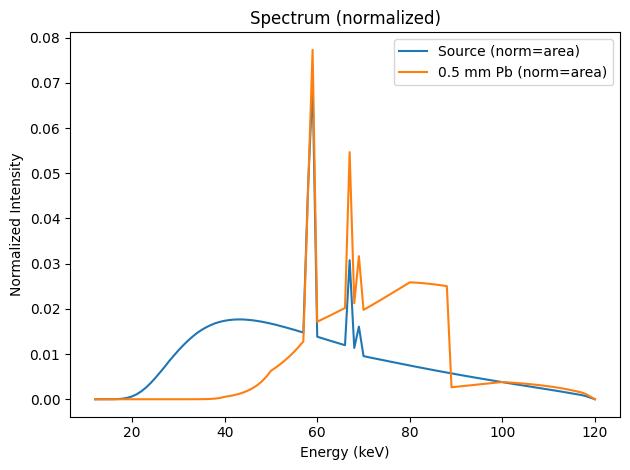

In [4]:
# ---------- (可选) 画图（归一化对比：area 或 peak） ----------
try:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.integrate import trapezoid

    norm_mode = "area"   # 可选: "area" 或 "peak"

    def normalize(E, Y, mode="area"):
        Y = np.asarray(Y, float)
    
        # 兼容 NumPy 1.x / 2.x：优先用 trapezoid，若不存在则回退 trapz
        trap = getattr(np, "trapezoid", np.trapz)
    
        if mode == "area":
            area = trapezoid(np.maximum(Y, 0), E)
            return Y / area if area > 0 else Y
        elif mode == "peak":
            m = np.max(Y) if Y.size else 0.0
            return Y / m if m > 0 else Y
        else:
            return Y

    Phi_in_n  = normalize(E_keV, Phi_in,  norm_mode)
    Phi_out_n = normalize(E_keV, Phi_out, norm_mode)

    plt.plot(E_keV, Phi_in_n,  label=f"Source (norm={norm_mode})")
    plt.plot(E_keV, Phi_out_n, label=f"0.5 mm Pb (norm={norm_mode})")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Normalized Intensity")
    plt.title("Spectrum (normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass